In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from alg_functions import *

# Obtain the Data

In [2]:
red_dwarfs = pd.read_csv('datasets/red_dwarfs.csv')
white_dwarfs = pd.read_csv('datasets/white_dwarfs.csv')

red_dwarfs['type'] = 'red'
white_dwarfs['type'] = 'white'

red_dwarfs = red_dwarfs[red_dwarfs['subclass'].str.startswith('K') | red_dwarfs['subclass'].str.startswith('M')]
white_dwarfs = white_dwarfs[white_dwarfs['subclass'] == 'WD']

red_dwarfs = red_dwarfs.iloc[:2000]
white_dwarfs = white_dwarfs.iloc[:2000]

dwarfs = pd.concat([red_dwarfs, white_dwarfs], ignore_index=True)

dwarfs = dwarfs.dropna()

display(dwarfs.head())

,spectroFlux_u,spectroFlux_g,spectroFlux_r,spectroFlux_i,spectroFlux_z,class,subclass,type
0,0.690362,2.639864,6.609772,9.040903,10.89239,STAR,K1,red
1,1.696024,5.127242,11.380340,15.288570,18.13893,STAR,K1,red
2,1.939370,6.556342,14.391160,19.006530,22.24492,STAR,K1,red
3,2.038488,9.414086,19.352240,25.074530,29.21216,STAR,K1,red
4,1.535014,5.447570,11.538370,15.077310,20.65042,STAR,K1,red


In [3]:
dwarfs['u-g'] = dwarfs['spectroFlux_u'] - dwarfs['spectroFlux_g']
dwarfs['g-r'] = dwarfs['spectroFlux_g'] - dwarfs['spectroFlux_r']
dwarfs['r-i'] = dwarfs['spectroFlux_r'] - dwarfs['spectroFlux_i']
dwarfs['i-z'] = dwarfs['spectroFlux_i'] - dwarfs['spectroFlux_z']
dwarfs['u-r'] = dwarfs['spectroFlux_u'] - dwarfs['spectroFlux_r']
dwarfs['r-z'] = dwarfs['spectroFlux_r'] - dwarfs['spectroFlux_z']
dwarfs['u-z'] = dwarfs['spectroFlux_u'] - dwarfs['spectroFlux_z']

pred_columns_dwarfs = ['u-g', 'g-r', 'r-i', 'i-z']

display(dwarfs.head())

,spectroFlux_u,spectroFlux_g,spectroFlux_r,spectroFlux_i,spectroFlux_z,class,subclass,type,u-g,g-r,r-i,i-z,u-r,r-z,u-z
0,0.690362,2.639864,6.609772,9.040903,10.89239,STAR,K1,red,-1.949502,-3.969908,-2.431131,-1.851487,-5.919410,-4.282618,-10.202028
1,1.696024,5.127242,11.380340,15.288570,18.13893,STAR,K1,red,-3.431218,-6.253098,-3.908230,-2.850360,-9.684316,-6.758590,-16.442906
2,1.939370,6.556342,14.391160,19.006530,22.24492,STAR,K1,red,-4.616972,-7.834818,-4.615370,-3.238390,-12.451790,-7.853760,-20.305550
3,2.038488,9.414086,19.352240,25.074530,29.21216,STAR,K1,red,-7.375598,-9.938154,-5.722290,-4.137630,-17.313752,-9.859920,-27.173672
4,1.535014,5.447570,11.538370,15.077310,20.65042,STAR,K1,red,-3.912556,-6.090800,-3.538940,-5.573110,-10.003356,-9.112050,-19.115406


# Algorithm 1

In [4]:
for epsilon in [0.01, 0.001, 0.0001]:
    print('epsilon: ', epsilon)

    train_set = dwarfs[dwarfs['type'] == 'white']

    # Remove outliers with z-score
    #outliers = train_set[(np.abs(stats.zscore(train_set[pred_columns_dwarfs])) > 3).all(axis=1)]
    #train_set = train_set.drop(outliers.index)

    c, r, k, chi, timer, delta, core_size = frank_wolfe_alg_MEB(epsilon, train_set[pred_columns_dwarfs].values)

    distances = np.linalg.norm(dwarfs[pred_columns_dwarfs] - c, axis=1)
    dwarfs['InsideBall'] = distances < r
    print(measure_accuracy('red', 'white', dwarfs))
    print('---------------')

epsilon:  0.01
Center: [140.52804351 213.88566069  85.86509275  37.62491031]
Radius: 325.05716271240453
Iterations: 5
CPU time: 0.029710054397583008
Core Set Size: 4
                Metric        Count
0   True Positive (TP)  1999.000000
1  False Negative (FN)     1.000000
2   True Negative (TN)   381.000000
3  False Positive (FP)  1581.000000
4            Precision     0.558380
5               Recall     0.999500
6             F1 Score     0.716487
---------------
epsilon:  0.001
Center: [140.72559632 216.15189978  87.89006649  39.14004694]
Radius: 322.55120057514245
Iterations: 11
CPU time: 0.055941104888916016
Core Set Size: 4
                Metric        Count
0   True Positive (TP)  1999.000000
1  False Negative (FN)     1.000000
2   True Negative (TN)   423.000000
3  False Positive (FP)  1539.000000
4            Precision     0.565008
5               Recall     0.999500
6             F1 Score     0.721921
---------------
epsilon:  0.0001
Center: [140.74162857 216.37800544  88.09

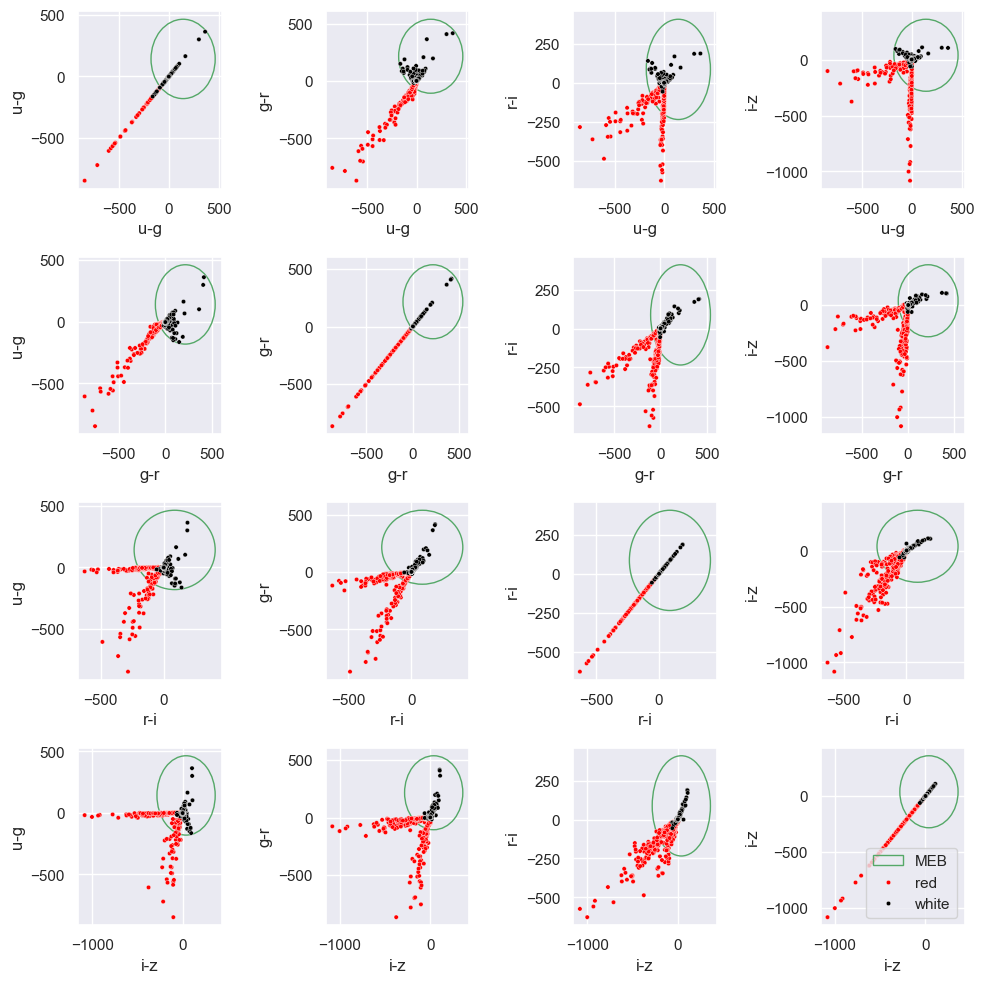

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming dwarfs is your DataFrame and c, r are defined

# Set seaborn style
sns.set(style="darkgrid")

# Create a scatter plot grid using Seaborn
fig, axs = plt.subplots(len(pred_columns_dwarfs), len(pred_columns_dwarfs), figsize=(10, 10))

# Loop through each pair of columns
for i in range(len(pred_columns_dwarfs)):
    for j in range(len(pred_columns_dwarfs)):
        ax = axs[i, j]
        ax.cla()

        # Add the MEB circle
        circle = plt.Circle(tuple(c[[i, j]]), r, color='g', fill=False, label='MEB')
        ax.add_patch(circle)

        # Use Seaborn's scatterplot for improved aesthetics
        sns.scatterplot(data=dwarfs, x=pred_columns_dwarfs[i], y=pred_columns_dwarfs[j], hue='type',
                        palette={'red': 'red', 'white': 'black'}, s=10, ax=ax)

        ax.set_xlabel(pred_columns_dwarfs[i])
        ax.set_ylabel(pred_columns_dwarfs[j])

        ax.get_legend().remove()

# Adjust layout
plt.tight_layout()

plt.legend(loc='lower right')
# Display the plot
plt.show()


# Algorithm 2

In [6]:
for epsilon in [0.01, 0.001, 0.0001]:

    print('---------------')
    print('Epsilon: ', epsilon)

    # Run the Away Step Frank-Wolfe algorithm
    center_as, radius_as, count_iterations_as, CPU_time_as, dual_val_list_as, dual_gap_list_as, core_size_as = frankWolfe_AwayStep(dwarfs[dwarfs['type'] == 'white'][pred_columns_dwarfs].values, epsilon)

    # Calculate Accuracies
    distances = np.linalg.norm(dwarfs[pred_columns_dwarfs] - center_as, axis=1)
    dwarfs['InsideBall'] = distances < radius_as
    print(measure_accuracy('red', 'white', dwarfs))

---------------
Epsilon:  0.01
Center: [140.74348788 216.40485735  88.11767317  39.31056424]
Radius: 322.27456525470416
Iterations: 25
CPU time: 0.6770758628845215
Set Size: 3
                Metric        Count
0   True Positive (TP)  1998.000000
1  False Negative (FN)     2.000000
2   True Negative (TN)   427.000000
3  False Positive (FP)  1535.000000
4            Precision     0.565525
5               Recall     0.999000
6             F1 Score     0.722212
---------------
Epsilon:  0.001
Center: [140.74348931 216.4048643   88.11767907  39.31056861]
Radius: 322.2745652547044
Iterations: 28
CPU time: 0.6856429576873779
Set Size: 3
                Metric        Count
0   True Positive (TP)  1999.000000
1  False Negative (FN)     1.000000
2   True Negative (TN)   427.000000
3  False Positive (FP)  1535.000000
4            Precision     0.565648
5               Recall     0.999500
6             F1 Score     0.722443
---------------
Epsilon:  0.0001
Center: [140.74348837 216.40486438  88.

# Algorithm 3

In [7]:
for epsilon in [0.01, 0.001, 0.0001]:

    print('---------------')
    print('Epsilon: ', epsilon)

    # Run the Pairwise Frank-Wolfe algorithm
    center_pw, radius_pw, count_iterations_pw, CPU_time_pw, dual_val_list_pw, dual_gap_list_pw, core_size_pw = frankWolfe_Pairwise(dwarfs[dwarfs['type'] == 'white'][pred_columns_dwarfs].values, epsilon)

    # Calculate Accuracies
    distances = np.linalg.norm(dwarfs[pred_columns_dwarfs] - center_pw, axis=1)
    dwarfs['InsideBall'] = distances < radius_pw
    print(measure_accuracy('red', 'white', dwarfs))

---------------
Epsilon:  0.01
Center: [140.74348763 216.40486564  88.11768095  39.31057011]
Radius: 322.2745652547043
Iterations: 25
CPU time: 0.6093709468841553
Set Size: 3
                Metric        Count
0   True Positive (TP)  1999.000000
1  False Negative (FN)     1.000000
2   True Negative (TN)   427.000000
3  False Positive (FP)  1535.000000
4            Precision     0.565648
5               Recall     0.999500
6             F1 Score     0.722443
---------------
Epsilon:  0.001
Center: [140.74348862 216.40486461  88.11767962  39.31056906]
Radius: 322.2745652547044
Iterations: 26
CPU time: 0.631784200668335
Set Size: 3
                Metric        Count
0   True Positive (TP)  1998.000000
1  False Negative (FN)     2.000000
2   True Negative (TN)   427.000000
3  False Positive (FP)  1535.000000
4            Precision     0.565525
5               Recall     0.999000
6             F1 Score     0.722212
---------------
Epsilon:  0.0001
Center: [140.74348836 216.40486448  88.11

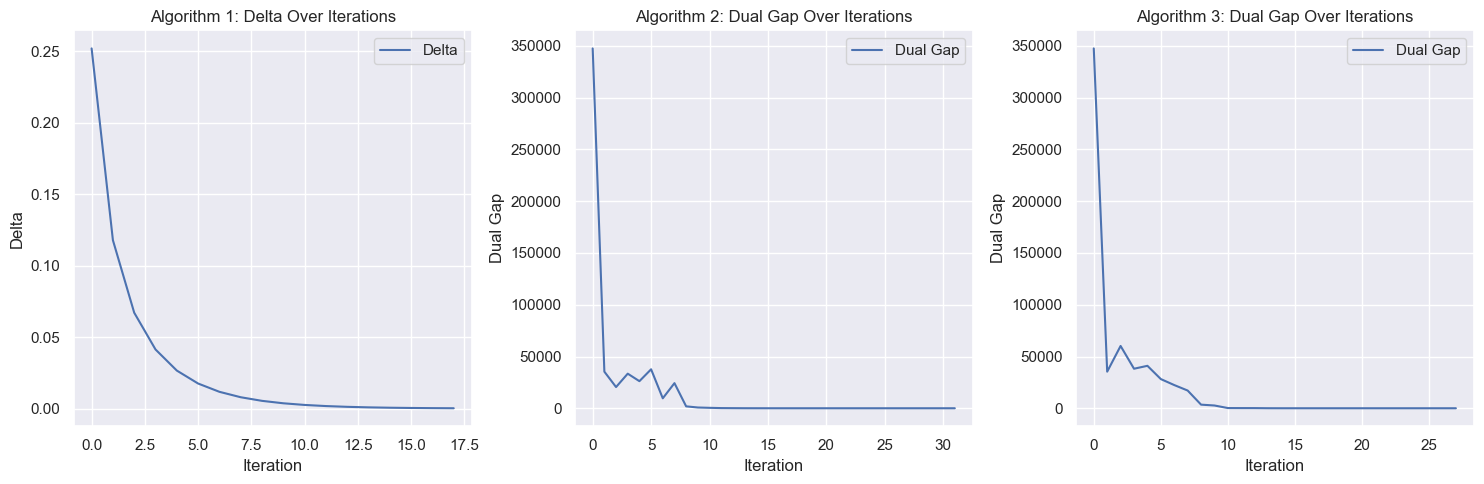

In [8]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.lineplot(ax=axs[0], data=delta, color='b', label='Delta')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Delta')
axs[0].set_title('Algorithm 1: Delta Over Iterations')

sns.lineplot(ax=axs[1], data=dual_gap_list_as, color='b', label='Dual Gap')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Dual Gap')
axs[1].set_title('Algorithm 2: Dual Gap Over Iterations')

sns.lineplot(ax=axs[2], data=dual_gap_list_pw, color='b', label='Dual Gap')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Dual Gap')
axs[2].set_title('Algorithm 3: Dual Gap Over Iterations')

plt.tight_layout()
plt.show()

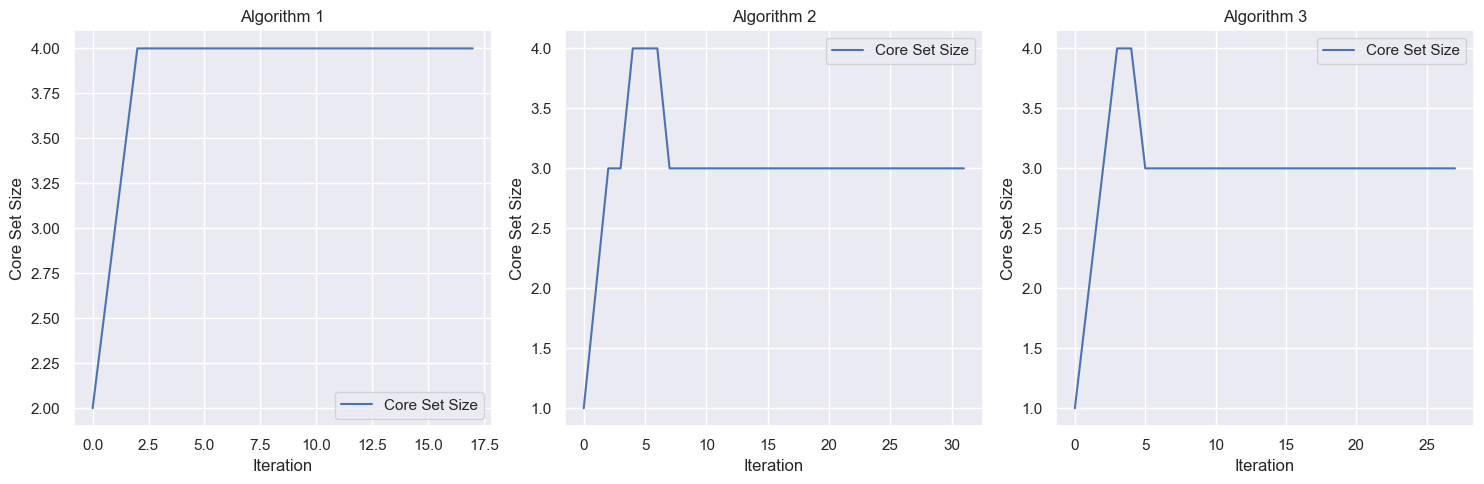

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.lineplot(ax=axs[0], data=core_size, color='b', label='Core Set Size')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Core Set Size')
axs[0].set_title('Algorithm 1')

sns.lineplot(ax=axs[1], data=core_size_as, color='b', label='Core Set Size')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Core Set Size')
axs[1].set_title('Algorithm 2')

sns.lineplot(ax=axs[2], data=core_size_pw, color='b', label='Core Set Size')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Core Set Size')
axs[2].set_title('Algorithm 3')

plt.tight_layout()
plt.show()